## **Libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import RandomOverSampler

from google.colab import drive
from google.colab import files

import string
import re

import subprocess
import sys

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'transformers'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'torch'])

import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler

from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

import time

from nltk.sentiment import SentimentIntensityAnalyzer

from tqdm.notebook import tqdm

nltk.download('vader_lexicon')

#!pip install transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from transformers import pipeline
from tqdm import tqdm


from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


## **Load and Preprocessing phase**

We are loading 10 dataset from https://www.kaggle.com/datasets/cynthiarempel/amazon-us-customer-reviews-dataset

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_paths = [
    '/content/drive/MyDrive/DF/amazon_reviews_us_Digital_Software_v1_00.tsv',
    '/content/drive/MyDrive/DF/amazon_reviews_us_Gift_Card_v1_00.tsv',
    '/content/drive/MyDrive/DF/amazon_reviews_us_Personal_Care_Appliances_v1_00.tsv',
    '/content/drive/MyDrive/DF/amazon_reviews_us_Mobile_Electronics_v1_00.tsv',
    '/content/drive/MyDrive/DF/amazon_reviews_us_Major_Appliances_v1_00.tsv',
    '/content/drive/MyDrive/DF/amazon_reviews_us_Digital_Video_Games_v1_00.tsv',
    '/content/drive/MyDrive/DF/amazon_reviews_us_Software_v1_00.tsv',
    '/content/drive/MyDrive/DF/amazon_reviews_us_Musical_Instruments_v1_00.tsv',
    '/content/drive/MyDrive/DF/amazon_reviews_us_Video_v1_00.tsv',
    '/content/drive/MyDrive/DF/amazon_reviews_us_Digital_Music_Purchase_v1_00.tsv',
]

In [ ]:
df = pd.DataFrame()

for file_path in file_paths:
    temp_df = pd.read_csv(file_path, sep='\t', on_bad_lines='skip')[['review_body', 'review_headline', 'star_rating', 'verified_purchase']]
    df = pd.concat([df, temp_df])

In [ ]:
df.head()

,review_body,review_headline,star_rating,verified_purchase
0,So far so good,Four Stars,4.0,Y
1,Needs a little more work.....,Three Stars,3.0,Y
2,Please cancel.,One Star,1.0,Y
3,Works as Expected!,Works as Expected!,5.0,Y
4,I've had Webroot for a few years. It expired a...,Great antivirus. Worthless customer support,4.0,Y


In [ ]:
df.isnull().sum()

review_body          217
review_headline       91
star_rating            4
verified_purchase      4
dtype: int64

In [ ]:
df = df.dropna()
df.isnull().sum()

review_body          0
review_headline      0
star_rating          0
verified_purchase    0
dtype: int64

In [ ]:
df.head()

,review_body,review_headline,star_rating,verified_purchase
0,So far so good,Four Stars,4.0,Y
1,Needs a little more work.....,Three Stars,3.0,Y
2,Please cancel.,One Star,1.0,Y
3,Works as Expected!,Works as Expected!,5.0,Y
4,I've had Webroot for a few years. It expired a...,Great antivirus. Worthless customer support,4.0,Y


In [ ]:
df['star_rating'] = df['star_rating'].astype(int)
df['sentiment'] = df['star_rating'].apply(lambda x: 'positive' if x > 3 else ('neutral' if x == 3 else 'negative'))
df.head()


#df = df[df['verified_purchase']=="Y"]
#df = df[['review_body', 'review_headline', 'sentiment']]
print(df.shape)

(3989465, 5)


In [ ]:
label_counts = df['sentiment'].value_counts()
print(f"Count of each label:\n{label_counts}")

Count of each label:
sentiment
positive    3287848
negative     460650
neutral      240967
Name: count, dtype: int64


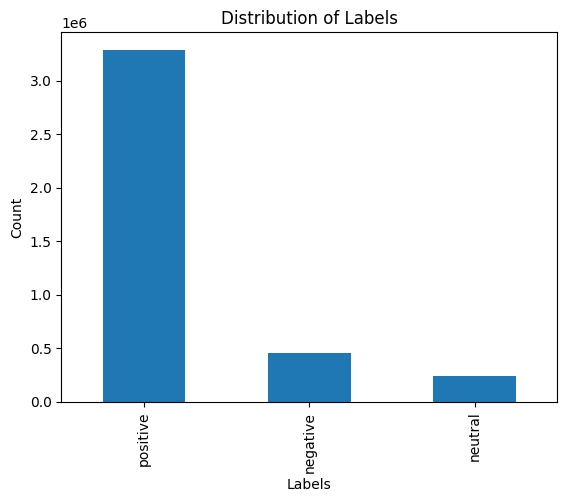

In [ ]:
label_counts.plot(kind='bar')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()

In [ ]:
positive = df[df['sentiment'] == 'positive']
neutral = df[df['sentiment'] == 'neutral']
negative = df[df['sentiment'] == 'negative']

In [ ]:
n_samples = 20000

In [ ]:
positive_balanced = resample(positive, replace=True, n_samples=n_samples, random_state=42)
neutral_balanced = resample(neutral, replace=True, n_samples=n_samples, random_state=42)
negative_balanced = resample(negative, replace=True, n_samples=n_samples, random_state=42)

In [ ]:
df_balanced = pd.concat([positive_balanced, neutral_balanced, negative_balanced])

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

df_balanced.head()

,review_body,review_headline,star_rating,verified_purchase,sentiment
0,"A highly unusual noir that starts off really, ...",Outstanding noir,5,Y,positive
1,"Like some other reviewers, I got this as a Fes...",Would have been perfect if I got what I ordered,3,Y,neutral
2,Well I'm sure that you realize by now that mos...,Switching from Deluxe to Elite in mid stream d...,3,Y,neutral
3,Perfect Functionality. Check your Microwave m...,You spin me right round baby right round...,5,Y,positive
4,As expected.,Five Stars,5,Y,positive


In [ ]:
print(f"\nShape of the balanced dataset: {df_balanced.shape}\n")


Shape of the balanced dataset: (60000, 5)



In [ ]:
print("\nNumber of examples for each sentiment class:")
print(df_balanced['sentiment'].value_counts())


Number of examples for each sentiment class:
sentiment
positive    20000
neutral     20000
negative    20000
Name: count, dtype: int64


In [ ]:
label_counts_b = df_balanced['sentiment'].value_counts()
print(f"Count of each label:\n{label_counts_b}")

Count of each label:
sentiment
positive    20000
neutral     20000
negative    20000
Name: count, dtype: int64


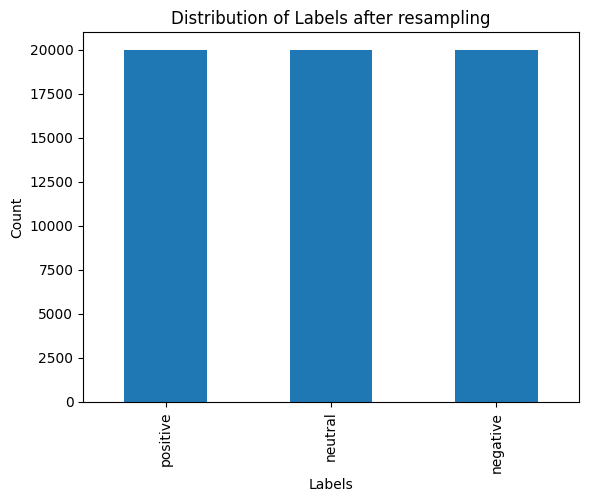

In [ ]:
label_counts_b.plot(kind='bar')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels after resampling')
plt.show()

Now we can perform the text pre-processing.

In [ ]:
def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return lemmatized_tokens

def remove_special_characters(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

def preprocess_text(text):
    text = clean_text(text)
    tokens = tokenize_and_remove_stopwords(text)
    lemmatized_tokens = lemmatize(tokens)
    text = ' '.join(lemmatized_tokens)
    text = remove_special_characters(text)
    return text

In [ ]:
#df_balanced['cleaned_review_body_lc'] = df_balanced['review_body'].apply(clean_text)
#df_balanced['cleaned_review_body_sc'] = df_balanced['review_body'].apply(remove_special_characters)
#df_balanced['cleaned_review_body_sc+lc'] = df_balanced['cleaned_review_body_lc'].apply(remove_special_characters)
df_balanced['cleaned_review_body'] = df_balanced['review_body'].apply(preprocess_text)

In [ ]:
df_balanced = df_balanced.dropna()
df_balanced.isnull().sum()

review_body                0
review_headline            0
star_rating                0
verified_purchase          0
sentiment                  0
cleaned_review_body_tot    0
cleaned_review_body        0
dtype: int64

In [ ]:
df_balanced.head()

,review_body,review_headline,star_rating,verified_purchase,sentiment,cleaned_review_body_tot,cleaned_review_body
0,"A highly unusual noir that starts off really, ...",Outstanding noir,5,Y,positive,highly unusual noir start really really dark g...,highly unusual noir start really really dark g...
1,"Like some other reviewers, I got this as a Fes...",Would have been perfect if I got what I ordered,3,Y,neutral,like reviewer got festivus pole think itll wor...,like reviewer got festivus pole think itll wor...
2,Well I'm sure that you realize by now that mos...,Switching from Deluxe to Elite in mid stream d...,3,Y,neutral,well im sure realize u previously used deluxe ...,well im sure realize u previously used deluxe ...
3,Perfect Functionality. Check your Microwave m...,You spin me right round baby right round...,5,Y,positive,perfect functionality check microwave model nu...,perfect functionality check microwave model nu...
4,As expected.,Five Stars,5,Y,positive,expected,expected


################################################################################

**IMPORT OF THE DATASET FOR THE PROFESSOR**

In [ ]:
#run the below row to import the dataset
df_balanced = pd.read_csv("df_balanced.csv", sep='\t', on_bad_lines='skip')

################################################################################

In [ ]:
df_balanced.shape

(60000, 6)

In [ ]:
"""df_balanced.to_csv('my_dataframe.csv', index=False)

files.download('my_dataframe.csv')"""

"df_balanced.to_csv('my_dataframe.csv', index=False)\n\nfiles.download('my_dataframe.csv')"

In [ ]:
X = df_balanced['cleaned_review_body']
y = df_balanced['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (48000,) (48000,)
Test set shape: (12000,) (12000,)


In [ ]:
total_memory_bytes = df_balanced.memory_usage(deep=True).sum()

total_memory_kb = total_memory_bytes / 1024
total_memory_mb = total_memory_kb / 1024
total_memory_gb = total_memory_mb / 1024

print(f"Total memory usage: {total_memory_bytes} bytes")
print(f"Total memory usage: {total_memory_kb:.2f} KB")
print(f"Total memory usage: {total_memory_mb:.2f} MB")
print(f"Total memory usage: {total_memory_gb:.2f} GB")

Total memory usage: 83781768 bytes
Total memory usage: 81818.13 KB
Total memory usage: 79.90 MB
Total memory usage: 0.08 GB


## Logistic Regression

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [ ]:
print("\nLogistic Regression Model Evaluation")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)


Logistic Regression Model Evaluation
Accuracy: 0.6856
Classification Report:
              precision    recall  f1-score   support

    negative       0.71      0.72      0.71      4000
     neutral       0.60      0.57      0.58      4000
    positive       0.75      0.77      0.76      4000

    accuracy                           0.69     12000
   macro avg       0.68      0.69      0.68     12000
weighted avg       0.68      0.69      0.68     12000



##Bert

In [ ]:
X_train = X_train.astype(str).tolist()
X_test = X_test.astype(str).tolist()

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_text(text_list):
    if not all(isinstance(text, str) for text in text_list):
        raise ValueError("All items in the text_list should be strings.")
    return tokenizer(text_list, padding=True, truncation=True, return_tensors='pt')

try:
    train_encodings = tokenize_text(X_train)
    test_encodings = tokenize_text(X_test)
except ValueError as e:
    print(f"Error in tokenization: {e}")
    raise

In [ ]:
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
train_labels = torch.tensor([label_map[label] for label in y_train])
test_labels = torch.tensor([label_map[label] for label in y_test])

train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 5
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

scaler = GradScaler()
gradient_accumulation_steps = 2

gpu_usage = []
time_elapsed = []

In [ ]:
def train(model, train_loader, optimizer, scheduler, scaler, gradient_accumulation_steps):
    model.train()
    total_loss = 0
    optimizer.zero_grad()
    start_time = time.time()

    for step, batch in enumerate(train_loader):
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to('cuda')
        attention_mask = attention_mask.to('cuda')
        labels = labels.to('cuda')
        with autocast():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * gradient_accumulation_steps

        gpu_usage.append(torch.cuda.memory_allocated())
        time_elapsed.append(time.time() - start_time)

    return total_loss / len(train_loader)

def evaluate(model, test_loader):
    model.eval()
    preds = []
    true_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to('cuda')
            attention_mask = attention_mask.to('cuda')
            labels = labels.to('cuda')
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds.extend(torch.argmax(logits, dim=1).tolist())
            true_labels.extend(labels.tolist())
    return preds, true_labels

model.to('cuda')

In [ ]:
epochs = 5
for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, scheduler, scaler, gradient_accumulation_steps)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss}')
    torch.cuda.empty_cache()

In [ ]:
preds, true_labels = evaluate(model, test_loader)

accuracy = accuracy_score(true_labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average='weighted')
report = classification_report(true_labels, preds, target_names=['negative', 'neutral', 'positive'])

print(f'Test Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(report)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(time_elapsed, gpu_usage, label='GPU Usage (bytes)')
plt.xlabel('Time (seconds)')
plt.ylabel('GPU Usage (bytes)')
plt.title('GPU Usage vs Time')
plt.legend()
plt.show()


# VADER

In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
def analyze_sentiments(df, columns):
    sid_obj = SentimentIntensityAnalyzer()

    def sentiment_scores(sentence):
        sentiment_dict = sid_obj.polarity_scores(sentence)
        if sentiment_dict['compound'] >= 0.05:
            return "positive"
        elif sentiment_dict['compound'] <= -0.05:
            return "negative"
        else:
            return "neutral"

    metrics = {}

    for column in columns:
        print(f"Processing column: {column}")

        if isinstance(df[column].iloc[0], list):
            df[column] = df[column].apply(lambda x: ' '.join(x))

        tqdm.pandas(desc=f"Sentiment Analysis for {column}")
        df[f'sentiment_new_{column}'] = df[column].progress_apply(sentiment_scores)

        if 'sentiment' in df.columns:
            y_true = df['sentiment']
            y_pred = df[f'sentiment_new_{column}']

            accuracy = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
            recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
            f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

            metrics[column] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1
            }

            print(f"Metrics for {column}:")
            print(f"Accuracy: {accuracy}")
            print(f"Precision: {precision}")
            print(f"Recall: {recall}")
            print(f"F1 Score: {f1}")

    return metrics, df

In [ ]:
columns_to_analyze = ['cleaned_review_body']
metrics, df = analyze_sentiments(df_balanced, columns_to_analyze)

Processing column: cleaned_review_body


Sentiment Analysis for cleaned_review_body: 100%|██████████| 60000/60000 [01:00<00:00, 987.08it/s] 


Metrics for cleaned_review_body:
Accuracy: 0.4465
Precision: 0.4570499807343811
Recall: 0.44649999999999995
F1 Score: 0.382407801167977


In [ ]:
df_balanced.head()

# Roberta Pretrained Model

In [ ]:
X_train = X_train.astype(str).tolist()
X_test = X_test.astype(str).tolist()

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def tokenize_text(text_list):
    if not all(isinstance(text, str) for text in text_list):
        raise ValueError("All items in the text_list should be strings.")
    return tokenizer(text_list, padding=True, truncation=True, return_tensors='pt')

try:
    train_encodings = tokenize_text(X_train)
    test_encodings = tokenize_text(X_test)
except ValueError as e:
    print(f"Error in tokenization: {e}")
    raise

In [ ]:
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
train_labels = torch.tensor([label_map[label] for label in y_train])
test_labels = torch.tensor([label_map[label] for label in y_test])

train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [ ]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 5
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

scaler = GradScaler()
gradient_accumulation_steps = 2

In [ ]:
def train(model, train_loader, optimizer, scheduler, scaler, gradient_accumulation_steps):
    model.train()
    total_loss = 0
    optimizer.zero_grad()
    start_time = time.time()

    for step, batch in enumerate(train_loader):
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to('cuda')
        attention_mask = attention_mask.to('cuda')
        labels = labels.to('cuda')
        with autocast():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * gradient_accumulation_steps

        gpu_usage.append(torch.cuda.memory_allocated())
        time_elapsed.append(time.time() - start_time)

    return total_loss / len(train_loader)

def evaluate(model, test_loader):
    model.eval()
    preds = []
    true_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to('cuda')
            attention_mask = attention_mask.to('cuda')
            labels = labels.to('cuda')
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds.extend(torch.argmax(logits, dim=1).tolist())
            true_labels.extend(labels.tolist())
    return preds, true_labels

model.to('cuda')

In [ ]:
epochs = 5
for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, scheduler, scaler, gradient_accumulation_steps)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss}')
    torch.cuda.empty_cache()


In [ ]:
preds, true_labels = evaluate(model, test_loader)

accuracy = accuracy_score(true_labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average='weighted')
report = classification_report(true_labels, preds, target_names=['negative', 'neutral', 'positive'])


print(f'Test Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(report)

Epoch 1/5, Loss: 0.7050733156204224

Epoch 2/5, Loss: 0.5843052413463593

Epoch 3/5, Loss: 0.49785546310742695

Epoch 4/5, Loss: 0.4113095966180166

Epoch 5/5, Loss: 0.3352125936746597

Test Accuracy: 0.745

                  precision    recall  f1-score   support

    negative        0.79      0.72      0.75      4000
    neutral         0.64      0.69      0.66      4000
    positive        0.81      0.83      0.82      4000

    accuracy                            0.74     12000
    macro avg       0.75      0.74      0.75     12000
    weighted avg    0.75      0.74      0.75     12000


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(time_elapsed, gpu_usage, label='GPU Usage (bytes)')
plt.xlabel('Time (seconds)')
plt.ylabel('GPU Usage (bytes)')
plt.title('GPU Usage vs Time')
plt.legend()
plt.show()